In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

#### First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


#### Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


### Problem 1
Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.

In [17]:
testAfiles = os.listdir(test_folders[0])
for ii in range(3):
    im=os.path.join(test_folders[0],testA[ii])
Image(im)

In [20]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

### Problem 2
Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

In [21]:
xx=load_letter(train_folders[0],10)

./notMNIST_large/A
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121


In [22]:
xx.shape

(52909, 28, 28)

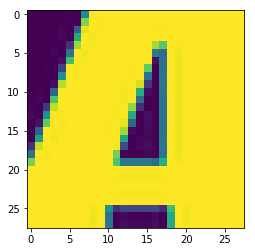

In [27]:
imshow(xx[40000])

### Problem 3
Another check: we expect the data to be balanced across classes. Verify that.

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [31]:
image_size
for label, pickle_file in enumerate(train_datasets):
    print(label,pickle_file)

0 ./notMNIST_large/A.pickle
1 ./notMNIST_large/B.pickle
2 ./notMNIST_large/C.pickle
3 ./notMNIST_large/D.pickle
4 ./notMNIST_large/E.pickle
5 ./notMNIST_large/F.pickle
6 ./notMNIST_large/G.pickle
7 ./notMNIST_large/H.pickle
8 ./notMNIST_large/I.pickle
9 ./notMNIST_large/J.pickle


In [32]:
def make_arrays(nb_rows, img_size): # make (empty) arrays of correct shape
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [33]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

mean and std -0.33869 0.320916


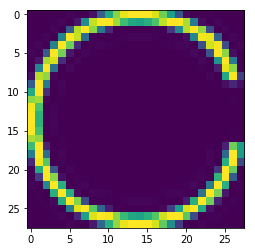

In [37]:
ii=1001  # problem 4 -- data still good after shuffle
xx=test_dataset[ii]
plt.figure()
plt.imshow(xx)
test_labels[ii]
print('mean and std',xx.mean(), xx.std())

### Problem 4
Convince yourself that the data is still good after shuffling!

Finally, let's save the data for later reuse:

In [35]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [36]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


### Problem 5
By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:

What about near duplicates between datasets? (images that are almost identical)
Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

In [111]:
# need to find and remove blank images first
def image_is_blank(im):
    imtmp = im-im.min()
    return imtmp.sum()==0

def count_blank_images(set):
    bindices = [ii for (ii,im) in enumerate(set) if image_is_blank(im)]
    return len(bindices)

def find_nonblank_images(set):
    nindices = [ii for (ii,im) in enumerate(set) if not image_is_blank(im)]
    return nindices

SHAPE2, SHAPE3=28,28  # hard code the image dims because they won't likely change
def filter_blanks(set): # filter out the blank images and return cleaned set
    nindices=find_nonblank_images(set) # nonblank indices
    outset=np.ndarray((len(nindices),SHAPE2,SHAPE3), dtype=np.float32)
    for ii, index in enumerate(nindices):
        outset[ii]=set[index]
    return outset

count_blank_images(test_dataset)
f_train_dataset=filter_blanks(train_dataset)  # 197948 images in filtered dataset
f_test_dataset=filter_blanks(test_dataset)    # 9875 ims
f_valid_dataset=filter_blanks(valid_dataset)  # 9898 ims

In [114]:
f_test_dataset.shape

(9875, 28, 28)

In [117]:
# problem 5 -- what is best way to find overlapping samples?
'''def images_are_the_same(im1, im2): # see if two images are equal
    return np.array_equal(im1, im2)'''

def overlap_between_sets(set1, set2): # how many overlaps are there between two sets     
    count=np.array([[np.array_equal(im1, im2) for im1 in set1] for im2 in set2]).sum()/2
    return count

def overlap_between_sets_for(set1, set2): # use a for loop to see if faster    
    count=0
    iindex=[]
    for jj,im1 in enumerate(set1):
        for ii,im2 in enumerate(set2):
            if np.array_equal(im1,im2):
                #return im1, im2
                iindex.append((jj,ii))
                count+=1  # should be double counted
    #return count
    return iindex

overlap_between_sets_for(f_valid_dataset, f_test_dataset)  # 26:27 is blank image, 178:179 blank, 192 blank
# overlap is less than 1% so that is prob ok, now that the blanks have been removed
# blanks would actually degrade the model and they were present also at 1%

[(195, 1994),
 (269, 2910),
 (458, 719),
 (703, 3096),
 (792, 8537),
 (969, 8023),
 (1061, 7533),
 (1096, 4664),
 (1161, 6220),
 (1304, 7404),
 (1346, 1497),
 (1398, 5573),
 (1398, 9001),
 (1421, 7052),
 (1597, 7190),
 (1801, 9517),
 (1813, 1235),
 (1830, 9793),
 (2442, 9487),
 (2580, 1617),
 (2851, 7932),
 (2914, 8567),
 (2933, 8694),
 (2933, 8998),
 (3041, 8652),
 (3274, 2258),
 (3353, 4122),
 (3674, 1388),
 (3937, 6010),
 (4193, 2838),
 (4338, 6069),
 (4479, 211),
 (4480, 6651),
 (4753, 1324),
 (4780, 9592),
 (4841, 1397),
 (4904, 2575),
 (4981, 2606),
 (4988, 6734),
 (5263, 1473),
 (5391, 1583),
 (5535, 3789),
 (5547, 6204),
 (5600, 7024),
 (5600, 7490),
 (5831, 2611),
 (5914, 650),
 (6128, 6215),
 (6292, 719),
 (6342, 1788),
 (6536, 5921),
 (6711, 845),
 (6858, 4664),
 (7187, 6348),
 (7238, 6634),
 (7329, 4664),
 (7419, 1204),
 (7466, 3647),
 (7728, 5827),
 (7835, 4642),
 (7967, 4221),
 (8195, 4933),
 (8347, 9104),
 (8386, 8722),
 (8771, 4627),
 (8942, 5096),
 (9032, 1397),
 (9381

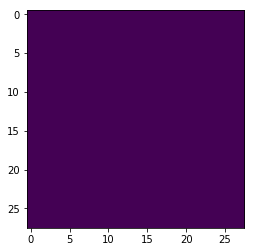

In [84]:
imshow(valid_dataset[192]) # rut-ro, there is a blank image, these should get cleaned out

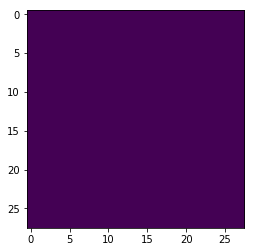

In [59]:
imshow(test_dataset[iindex[0]])

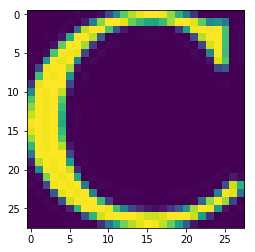

In [85]:
imshow(valid_dataset[198])

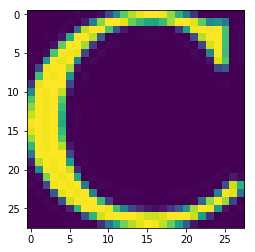

In [87]:
imshow(test_dataset[2023])

### Problem 6
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

In [33]:
import sklearn.linear_model as sklm

In [42]:
def vectorize_image(image):
    '''turn an image into a vector so it can be used for regression expecting <=2D data'''
    return image.reshape(-1)

In [59]:
number_of_samples=1000

test=sklm.LogisticRegression()
vtrain_dataset=np.array([vectorize_image(im) for im in train_dataset[:number_of_samples]])
vtrain_labels=train_labels[:number_of_samples]
test.fit(vtrain_dataset, vtrain_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
test_samples=5000
# very slow
vtest_dataset=np.array([vectorize_image(im) for im in test_dataset[:test_samples]])
vtest_labels=train_labels[:test_samples]
res=test.predict(vtest_dataset)-vtest_labels
# try using test.score(X,y) to get accuracy

In [63]:
# well that does not seem to work very well. About one in ten has zero error
[len([e for e in res if e==ii-9]) for ii in range(20)]

[57,
 120,
 143,
 188,
 253,
 316,
 341,
 387,
 432,
 471,
 463,
 380,
 352,
 303,
 288,
 205,
 141,
 100,
 60,
 0]

In [64]:
[len([e for e in vtest_labels if e==ii]) for ii in range(10)]

[511, 503, 489, 489, 490, 482, 495, 526, 472, 543]